In [1]:
# sys tools
import sys
import time
import argparse

# data tools
import h5py
import zarr
import numpy as np
import numba as nb

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')

#import data_utils as du
#import analog_utils as ana


In [2]:
from datetime import datetime

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/')

from namelist_casper import * 

In [4]:
import pygrib

In [5]:
def leap_year_checker(y):
    if y % 400 == 0:
        return True
    if y % 100 == 0:
        return False
    if y % 4 == 0:
        return True
    else:
        return False

In [6]:
@nb.njit()
def shift_one(arr):
    arr[1:] = arr[:-1]
    return arr

@nb.njit()
def search_nearby_days(day, window=30, leap_year=False):
    '''
    Assuming "day" starts at zero
    Assuming 2*window < 365 
    '''
    if leap_year:
        N_days = 366
        ind_date = np.zeros((N_days,))
    else:
        N_days = 365
        ind_date = np.zeros((N_days,))
        
    ind_right = day+window+1
    ind_left = day-window
    
    if ind_left >= 0 and ind_right <= N_days:
        ind_date[day-window:day+window+1] = True
    elif ind_left < 0:
        ind_date[0:day+window+1] = True
        ind_date[day-window:] = True
    else:
        ind_diff = day+window+1-N_days
        ind_date[day-window:] = True
        ind_date[:ind_diff] = True
    return ind_date

@nb.njit()
def analog_search_SL_single_day(day_ini, year_analog, fcst_apcp, fcst_pwat, APCP, PWAT, ERA5, EN, SL_xy, flag_leap_year):
    
    # params that can be adjusted
    #EN = 75 # number of AnEn members
    N_SL = 20 # number of suplemental locations
    N_grids = fcst_apcp.shape[0] # number of grid points
    window_day = 30 # time window (by days) of the analog search 
    shape_ravel = (2*window_day+1, N_SL)
    
    # output
    AnEn = np.empty((N_grids, EN))
    
    # allocate single day, grid, and year
    day_n = np.empty((EN,), np.int_)
    ind_n = np.empty((EN,), np.int_)
    year_n = np.empty((EN,), np.int_)
    record_n = np.ones((EN,))
    day_per_sl = 0
    #
    # datetime related variables
    day_365 = np.arange(365)
    day_366 = np.arange(366)
    
    if flag_leap_year:
        mon_ind_all = [ 
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
    else:
        mon_ind_all = [ 
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
    
    # selecting initialization month, and corresponded SL for all grids
    ind_month = mon_ind_all[day_ini]
    SL_mon = SL_xy[ind_month]
        
    # loop over grid points
    for n in range(N_grids):
        # fcst values
        apcp_new = fcst_apcp[n,]
        pwat_new = fcst_pwat[n,]
            
        # initialize analog selction records
        record_n[:] = 9999
            
        # loop over reforecast
        for year_ind, year_ana in enumerate(year_analog):
                
            # the 91-day window of analog search
            if year_ana%4 == 0:
                flag_analog_days = search_nearby_days(day_ini, window=window_day, leap_year=True)
                # True/Flase flag to indices
                day_base = day_366[flag_analog_days==1]
                
            else:
                flag_analog_days = search_nearby_days(day_ini, window=window_day, leap_year=False)
                day_base = day_365[flag_analog_days==1]
                
            # sumplemental locations in "month" and "grid n"
            inds_to_inds = SL_mon[n, :] # the input are "indexed" vectors, here create an index for the indexed, so it's named as inds_to_inds 
            
            # loop over a single SL (including itself)
            for s in range(shape_ravel[1]):
                
                # sl inds to actual inds
                ind_real = inds_to_inds[s]
                    
                # in place analog search
                if s == 0:
                    # loop over the time window
                    for d in range(shape_ravel[0]):
                            
                        day_real = int(day_base[d])
                        apcp_old = APCP[year_ind][day_real, ind_real]
                        pwat_old = PWAT[year_ind][day_real, ind_real]

                        # analog criteria
                        record_temp = 0.76*np.abs(apcp_old - apcp_new) + 0.24*np.abs(pwat_old - pwat_new)
                        
                        # if in place analog hit the new record
                        if record_temp < record_n[-1]:
                            # searchosrt positions
                            ind_analog = np.searchsorted(record_n, record_temp)
                            # shift one from the position to free space
                            day_n[ind_analog:] = shift_one(day_n[ind_analog:])
                            ind_n[ind_analog:] = shift_one(ind_n[ind_analog:])
                            year_n[ind_analog:] = shift_one(year_n[ind_analog:])
                            record_n[ind_analog:] = shift_one(record_n[ind_analog:])
                            # insert
                            day_n[ind_analog] = day_real
                            ind_n[ind_analog] = ind_real
                            year_n[ind_analog] = year_ind
                            record_n[ind_analog] = record_temp
                    
                # SL analog search (one analog per year)
                else:
                    record_per_sl = 9999
                    # loop over the time window
                    for d in range(shape_ravel[0]):
                            
                        day_real = int(day_base[d])
                        apcp_old = APCP[year_ind][day_real, ind_real]
                        pwat_old = PWAT[year_ind][day_real, ind_real]
                        
                        # analog criteria of 0.7*APCP + 0.3*PWAT
                        record_temp = 0.76*np.abs(apcp_old - apcp_new) + 0.24*np.abs(pwat_old - pwat_new)
                        # update the best analog of this sl
                        if record_temp < record_per_sl:
                            record_per_sl = record_temp
                            day_per_sl = day_real
                        
                    # the best SL analog is allowed to participate
                    if record_per_sl < record_n[-1]:
                        # searchosrt positions
                        ind_analog = np.searchsorted(record_n, record_per_sl)

                        # shift one from the position to free space
                        day_n[ind_analog:] = shift_one(day_n[ind_analog:])
                        ind_n[ind_analog:] = shift_one(ind_n[ind_analog:])
                        year_n[ind_analog:] = shift_one(year_n[ind_analog:])
                        record_n[ind_analog:] = shift_one(record_n[ind_analog:])

                        # insert
                        day_n[ind_analog] = day_per_sl
                        ind_n[ind_analog] = ind_real
                        year_n[ind_analog] = year_ind
                        record_n[ind_analog] = record_per_sl
                            
        # back to the grid point loop
        # assigning ERA5 based on the (multi-year) reforecast search
        for en in range(EN):
            AnEn[n, en] = ERA5[year_n[en]][day_n[en], ind_n[en]]
    return AnEn

In [7]:
# importing domain information
# with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
#     land_mask = h5io['land_mask_base'][...]
#     land_mask_bc = h5io['land_mask_bc'][...]
# bc_in_base = np.ones(land_mask.shape).astype(bool)
# bc_in_base[bc_inds[0]:bc_inds[1], bc_inds[2]:bc_inds[3]] = land_mask_bc

# # subsetting by land mask
# bc_shape = land_mask_bc.shape
# grid_shape = land_mask.shape
# IND_bc = []
# for i in range(grid_shape[0]):
#     for j in range(grid_shape[1]):
#         if ~bc_in_base[i, j]:
#             IND_bc.append([i, j])
# IND_bc = np.array(IND_bc, dtype=np.int)
# N_grids = len(IND_bc)

In [8]:
# -------- Function ends -------- #

# parser = argparse.ArgumentParser()
# parser.add_argument('year_fcst', help='year_fcst')
# parser.add_argument('part', help='part')
# args = vars(parser.parse_args())
# year_fcst = int(args['year_fcst'])
# part_ = int(args['part'])
EN = 25

dt_utc_now = datetime.utcnow()
dt_fmt_string = datetime.strftime(dt_utc_now, '%Y%m%d')
dt_day_of_year = dt_utc_now.timetuple().tm_yday
dt_month_from_zero = dt_utc_now.month-1
flag_leap_year = leap_year_checker(dt_utc_now.year)

# ---------------------------------- #

# arg2
LEADs = np.arange(0, 54, dtype=np.int)
N_leads = len(LEADs)

In [9]:
year_analog = np.arange(2000, 2019)

# importing domain information
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    lat_bc = h5io['bc_lat'][...] # lats of the BC domain
    lon_bc = h5io['bc_lon'][...] # lons of the BC domain
    land_mask_bc = h5io['land_mask_bc'][...] # selecting OCEAN grids from the BC domain

ocean_mask_bc = np.logical_not(land_mask_bc) # selecting LAND grids from the BC domain

bc_shape = land_mask_bc.shape
N_grids = np.sum(ocean_mask_bc)

In [10]:
# supplemental locations
SL_xy_dict = {}
with h5py.File(save_dir+'SL20_d4_unique.hdf', 'r') as h5io:
    #IxIy_unique = h5io['unique_inds'][...]
    for i in range(12):
        temp = h5io['mon_{}_inds'.format(i)][...]
        temp = temp.astype(int)
        SL_xy_dict['{}'.format(i)] = temp
#IxIy_unique = IxIy_unique.astype(int)
SL_xy = tuple(SL_xy_dict.values())

In [11]:
AnEn_out = np.empty((N_leads, N_grids, EN))

In [12]:
#lead = LEADs[1]
for i, lead in enumerate(LEADs):
    lead_int_h = int(FCSTs[lead])
    #print("Processing lead time = {}".format(lead))
    #print("Main program starts ...")
    # ------------------------------------------------- #
    
    # Import reforecast
    APCP = ()
    PWAT = ()
    
    for year in year_analog:
        apcp_temp = zarr.load(BASE_dir+'BASE_APCP_year{}_lead{}.zarr'.format(year, lead))
        pwat_temp = zarr.load(BASE_dir+'BASE_PWAT_year{}_lead{}.zarr'.format(year, lead))
        
        APCP += (apcp_temp,)
        PWAT += (pwat_temp,)
        
    # ------------------------------------------------- #
    
    # Import reanalysis
    ERA5 = ()
    
    for year in year_analog:
        era_temp = zarr.load(BASE_dir+'BASE_ERA5_year{}_lead{}.zarr'.format(year, lead))
        
        ERA5 += (era_temp,)
        
    # ------------------------------------------------- #
    
    GEFS_dir_base = '/glade/scratch/ksha/DATA/GEFS/{}/'.format(dt_fmt_string)
    GEFS_dir_full = GEFS_dir_base+'geavg.t00z.pgrb2s.0p25.f{0:03d}'.format(lead_int_h)
    
    with pygrib.open(GEFS_dir_full) as grb_io:
        #
        grb_reader_apcp = grb_io.select(name='Total Precipitation')[0]
        apcp, _, _ = grb_reader_apcp.data(lat1=48.25, lat2=60.00, lon1=-141.0+360, lon2=-113.25+360)
        apcp = np.flipud(apcp) # GEFS default: kg/m**-2 (or mm) per 3 hours
        
        #
        grb_reader_pwat = grb_io.select(name='Precipitable water')[0]
        pwat, _, _ = grb_reader_pwat.data(lat1=48.25, lat2=60.00, lon1=-141.0+360, lon2=-113.25+360)
        pwat = np.flipud(pwat) # GEFS default: kg/m**-2 (or mm) per 3 hours
    
    apcp_flat = apcp[ocean_mask_bc]
    pwat_flat = apcp[ocean_mask_bc]
    
    start_time = time.time()
    AnEn = analog_search_SL_single_day(dt_day_of_year, year_analog, apcp_flat, pwat_flat, APCP, PWAT, ERA5, EN, SL_xy, flag_leap_year)
    #print("... Completed. Time = {} sec ".format((time.time() - start_time)))
    
    AnEn_out[i, ...] = AnEn

In [13]:
AnEn_out.shape

(54, 2574, 25)

# MDSS

In [14]:
#@nb.njit()
def schaake_shuffle(fcst, traj):
    '''
    The Schaake shuffle of ensemble `fcst` members
    based on given `traj`ectories.
    '''
    num_traj, N_lead, N_grids = traj.shape
    
    output = np.empty((N_lead, num_traj, N_grids))
    
    for l in range(N_lead):
        for n in range(N_grids):
            
            temp_traj = traj[:, l, n]
            temp_fcst = fcst[l, :, n]
            
            reverse_b_func = np.searchsorted(np.sort(temp_traj), temp_traj)
            
            output[l, :, n] = np.sort(temp_fcst)[reverse_b_func]
    return output

#@nb.njit()
def search_nearby_days(day, window=30, leap_year=False):
    '''
    Assuming "day" starts at zero
    Assuming 2*window < 365 
    '''
    if leap_year:
        N_days = 366
        ind_date = np.zeros((N_days,))
    else:
        N_days = 365
        ind_date = np.zeros((N_days,))
    
    ind_right = day+window+1
    ind_left = day-window
    
    if ind_left >= 0 and ind_right <= N_days:
        ind_date[day-window:day+window+1] = True
    elif ind_left < 0:
        ind_date[0:day+window+1] = True
        ind_date[day-window:] = True
    else:
        ind_diff = day+window+1-N_days
        ind_date[day-window:] = True
        ind_date[:ind_diff] = True
    return ind_date


In [43]:
@nb.njit()
def CDF_estimate(X):
    '''
    input_shape = (members/days, leads, grids)
    '''
    q_bins = np.array([0.25, 0.5, 0.7, 0.9, 0.95,])  
    _, N_fcst, N_grids = X.shape
    CDF = np.empty((5, N_fcst, N_grids))
    
    for lead in range(N_fcst):
        for n in range(N_grids):
            CDF[:, lead, n] = np.quantile(X[:, lead, n], q_bins)
    return CDF

@nb.njit()
def total_divergence(CDF1, CDF2):
    _, N_fcst, N_grids = CDF1.shape
    TD = 0
    for lead in range(N_fcst):
        for n in range(N_grids):
            TD += np.sum(np.abs(CDF1[:, lead, n] - CDF2[:, lead, n]))
    return TD

In [16]:
#@nb.njit()
def MDSS_single_day(fcst_raw, era5_H, N, K, factor=15):
    '''
    MDSS main function
    
    fcst_raw: fcst field needs to be shuffled. shape=(members, lead, grids, )
    era5_H: reference field, assuming ERA5. shape=(members, lead, grids, )
    N: number of ensemble members to produce
    '''
    
    CDF_fcst = CDF_estimate(fcst_raw)
    CDF_era = CDF_estimate(era5_H)
    
    # initial total divergence
    record = total_divergence(CDF_era, CDF_fcst)
    
    # stepwise shrinking
    ind_pick = np.arange(N, dtype=np.int_) # all available indices
    
    flag_clean = np.ones((N,), dtype=np.bool_) # output flag
    flag_trial = np.copy(flag_clean)
    
    N_0 = N
    
    flag_single = False
    black_list = []
    
    while N_0 > K:
        # all available candidate
        N_0 = np.sum(flag_clean)
        ind_candidate = ind_pick[flag_clean]
        #print(N_0)
        
        # randomly selecting candidtes
        size_ = int((N_0-K)/(factor))
        
        if size_ > 5:
            ind_ = np.random.choice(range(N_0), size_, replace=False)
            for i in ind_:
                flag_trial[ind_candidate[i]] = False
        else:
            flag_single = True
            
            j = np.random.choice(ind_candidate, size=1)
            while j in black_list:
                j = np.random.choice(ind_candidate, size=1)
                
            flag_trial[j] = False
            
        era5_sub = era5_H[flag_trial, ...]
        CDF_era = CDF_estimate(era5_sub)
        record_temp = total_divergence(CDF_era, CDF_fcst)
        
        # stepwise discard
        if record_temp < record:
            #print('hit: {}'.format(record_temp))
            record = record_temp
            if flag_single:
                flag_clean[j] = False
            else:
                flag_clean = np.copy(flag_trial)
        
        else:
            #print('miss: {}'.format(record_temp))
            if flag_single:
                flag_trial[j] = True
                black_list.append(j)
            else:
                flag_trial = np.copy(flag_clean)
                
    return flag_clean

In [17]:
year_mdss = np.arange(2010, 2019)

In [18]:
start_time = time.time()

ERA5_mdss = ()

window_day = 30
N_days = window_day*2 + 1

# loop over years for MDSS training
for year in year_mdss:
    
    # separate leap year
    if leap_year_checker(year):
        flag_pick = search_nearby_days(dt_day_of_year, window=30, leap_year=True)
    else:
        flag_pick = search_nearby_days(dt_day_of_year, window=30, leap_year=False)
        
    flag_pick = flag_pick == 1
    era_all_lead = np.empty((N_days, N_grids, N_leads))
    
    # loop over lead times
    for i, lead in enumerate(LEADs):
        era_temp = zarr.load(BASE_dir+'BC_ERA5_year{}_lead{}.zarr'.format(year, lead))
        era_all_lead[..., i] = era_temp[flag_pick, :]
    
    ERA5_mdss += (era_all_lead,)

ERA5_mdss = np.concatenate(ERA5_mdss)

print("... Completed. Time = {} sec ".format((time.time() - start_time)))

... Completed. Time = 171.53706312179565 sec 


In [19]:
flag_pick = search_nearby_days(dt_day_of_year, window=30, leap_year=True)

In [20]:
AnEn_out = np.transpose(AnEn_out, (2, 0, 1))

In [21]:
ERA5_mdss = np.transpose(ERA5_mdss, (0, 2, 1))

In [22]:
AnEn_out.shape

(25, 54, 2574)

In [23]:
ERA5_mdss.shape

(549, 54, 2574)

We need to cut ~500 to 25 meanwhile minimizing the distribution divergence.

In [24]:
#CDF_fcst = CDF_estimate(AnEn_out)
#CDF_ERA5 = CDF_estimate(ERA5_mdss)
#record = total_divergence(CDF_ERA5, CDF_fcst)

In [94]:
#CDF_ERA5.shape

(5, 54, 2574)

In [29]:
ERA5_mdss.shape

(549, 54, 2574)

In [38]:
N, N_leads, N_grids = ERA5_mdss.shape
K = 25 # number of sequences

CDF_fcst = CDF_estimate(AnEn_out)
CDF_ERA5 = CDF_estimate(ERA5_mdss)

# initial total divergence
record = total_divergence(CDF_ERA5, CDF_fcst)
print('initial record: {}'.format(record))

# stepwise shrinking
ind_pick = np.arange(N, dtype=np.int_) # all available indices

flag_clean = np.ones((N,), dtype=np.bool_) # output (the final pick)
flag_trial = np.copy(flag_clean) # temporal trial pick

N_0 = N
flag_single = False
black_list = []
factor = 5

count_trial = 0

while N_0 > K:
    
    # all available candidate
    ind_candidate = ind_pick[flag_clean]
    
    # Estimate the number to dropout
    size_ = int((N_0-K)/(factor))
    print('dropsize = {}'.format(size_))
    
    # If size > 5, perform batch dropout
    if size_ > 5:
        # generate dropout indices
        ind_ = np.random.choice(range(N_0), size_, replace=False)
    
        # update droput indices to the trial record
        for i in ind_:
            flag_trial[ind_candidate[i]] = False
    
    # If size_ <= 5, perform single dropout
    else:
        flag_single = True
    
        # generate the index to dropout
        j = np.random.choice(ind_candidate, size=1)
    
        while j in black_list:
            j = np.random.choice(ind_candidate, size=1)
    
        # update the index to the trial record
        flag_trial[j] = False
    
    # Subtrack the ERA5 CDFs
    ERA5_sub = ERA5_mdss[flag_trial, ...]
    CDF_ERA5 = CDF_estimate(ERA5_sub)
    
    record_temp = total_divergence(CDF_ERA5, CDF_fcst)
    print('temp record: {}'.format(record_temp))
    
    # stepwise discard
    
    # if divergence is reduced, update to the final output (clean)
    if record_temp < record:
        #print('hit: {}'.format(record_temp))
        record = record_temp
        if flag_single:
            flag_clean[j] = False
        else:
            flag_clean = np.copy(flag_trial)
    
    # if divergence not reduced, revert to the previous clean record
    else:
        #print('miss: {}'.format(record_temp))
        if flag_single:
            flag_trial[j] = True
            black_list.append(j)
        else:
            flag_trial = np.copy(flag_clean)
    
    N_0 = np.sum(flag_clean)
    print('N_0 = {}'.format(N_0))
    count_trial += 1

initial record: 499056.8863637943
dropsize = 104
temp record: 499883.79707348894
N_0 = 549
dropsize = 104
temp record: 492337.44349617744
N_0 = 445
dropsize = 84
temp record: 487899.616220221
N_0 = 361
dropsize = 67
temp record: 496164.67902924214
N_0 = 361
dropsize = 67
temp record: 489043.8851853959
N_0 = 361
dropsize = 67
temp record: 492401.90853064036
N_0 = 361
dropsize = 67
temp record: 489546.3989444654
N_0 = 361
dropsize = 67
temp record: 498682.5561202042
N_0 = 361
dropsize = 67
temp record: 482140.65783796826
N_0 = 294
dropsize = 53
temp record: 476929.2879401559
N_0 = 241
dropsize = 43
temp record: 479196.0644637503
N_0 = 241
dropsize = 43
temp record: 468634.57649132214
N_0 = 198
dropsize = 34
temp record: 463166.7250154829
N_0 = 164
dropsize = 27
temp record: 462091.3807271293
N_0 = 137
dropsize = 22
temp record: 468607.5629160963
N_0 = 137
dropsize = 22
temp record: 459498.8385695371
N_0 = 115
dropsize = 18
temp record: 451893.94263808976
N_0 = 97
dropsize = 14
temp recor

KeyboardInterrupt: 

In [39]:
ERA5_pick = ERA5_mdss[flag_clean]

In [40]:
ERA5_pick.shape

(49, 54, 2574)

In [41]:
CDF_fcst = CDF_estimate(AnEn_out)
CDF_ERA5 = CDF_estimate(ERA5_pick)
total_divergence(CDF_ERA5, CDF_fcst)

399463.44330033957

In [68]:
@nb.njit()
def MDSS_main(ERA5_mdss, AnEn_out, K=25, factor=5):
    N, N_leads, N_grids = ERA5_mdss.shape

    CDF_fcst = CDF_estimate(AnEn_out)
    CDF_ERA5 = CDF_estimate(ERA5_mdss)

    # initial total divergence
    record = total_divergence(CDF_ERA5, CDF_fcst)

    # stepwise shrinking
    ind_pick = np.arange(N, dtype=np.int_) # all available indices

    flag_clean = np.ones((N,), dtype=np.bool_) # output (the final pick)
    flag_trial = np.copy(flag_clean) # temporal trial pick

    N_0 = N
    flag_single = False
    black_list = np.array([9999,])
    count_trial = 0

    while N_0 > K:

        # all available candidate
        ind_candidate = ind_pick[flag_clean]

        # Estimate the number to dropout
        size_ = int((N_0-K)/(factor))

        # If size > 5, perform batch dropout
        if size_ > 5:
            # generate dropout indices
            ind_ = np.random.choice(np.arange(N_0), size_, replace=False)

            # update droput indices to the trial record
            for i in ind_:
                flag_trial[ind_candidate[i]] = False

        # If size_ <= 5, perform single dropout
        else:
            flag_single = True

            # generate the index to dropout
            j = np.random.choice(ind_candidate, size=1)

            #while j in black_list:
            while np.any(black_list == j):
                
                j = np.random.choice(ind_candidate, size=1)

            # update the index to the trial record
            flag_trial[j] = False

        # Subtrack the ERA5 CDFs
        ERA5_sub = ERA5_mdss[flag_trial, ...]
        CDF_ERA5 = CDF_estimate(ERA5_sub)

        record_temp = total_divergence(CDF_ERA5, CDF_fcst)
        #print('temp record: {}'.format(record_temp))

        # stepwise discard

        # if divergence is reduced, update to the final output (clean)
        if record_temp < record:
            #print('hit: {}'.format(record_temp))
            record = record_temp
            if flag_single:
                flag_clean[j] = False
            else:
                flag_clean = np.copy(flag_trial)

        # if divergence not reduced, revert to the previous clean record
        else:
            #print('miss: {}'.format(record_temp))
            if flag_single:
                
                flag_trial[j] = True
                
                black_list = np.append(black_list, j)
                
            else:
                flag_trial = np.copy(flag_clean)

        N_0 = np.sum(flag_clean)
        count_trial += 1
        
    return flag_clean, count_trial

In [ ]:
flag_clean = MDSS_main(ERA5_mdss, AnEn_out, K=25, factor=5)

In [89]:
# for i in range(300):
#     plt.figure()
#     plt.plot(CDF_AnEn[:, 0, i])
#     plt.plot(CDF_ERA5[:, 0, i])

In [13]:
anen_grid = np.empty((EN,)+bc_shape)
for en in range(EN):
    anen_grid[en, ocean_mask_bc] = AnEn[..., en]
anen_grid[:, land_mask_bc] = np.nan

In [14]:
fcst_grid = np.empty(bc_shape)
fcst_grid[ocean_mask_bc] = apcp_flat
fcst_grid[land_mask_bc] = np.nan

**MDSS**

In [15]:
AnEn.shape

(2574, 75)

In [68]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [27]:
anen_grid[0, ...] - anen_grid[-1, ...]

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.59561527, -0.34249751,  0.69458668, ...,         nan,
                nan,         nan],
       [-0.16440409,  3.37741359,  2.37081297, ...,         nan,
                nan,         nan]])

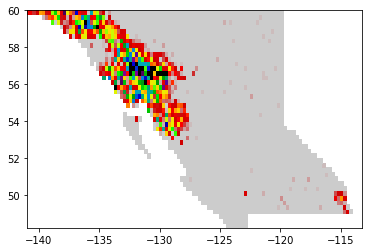

In [26]:
plt.pcolormesh(lon_bc, lat_bc, anen_grid[-1, ...], vmin=0, vmax=5, cmap=plt.cm.nipy_spectral_r)

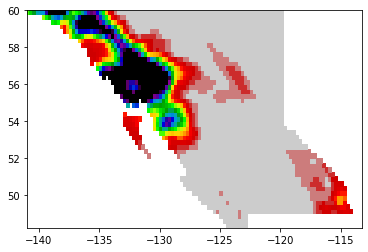

In [22]:
plt.pcolormesh(lon_bc, lat_bc, fcst_grid, vmin=0, vmax=5, cmap=plt.cm.nipy_spectral_r)

In [58]:
apcp.shape

(48, 112)

In [15]:
GEFS_dir = '/glade/scratch/ksha/DATA/GEFS/20220114/geavg.t00z.pgrb2s.0p25.f{0:03d}'.format(9)

In [16]:
GEFS_dir

'/glade/scratch/ksha/DATA/GEFS/20220114/geavg.t00z.pgrb2s.0p25.f009'

In [ ]:



    # ------------------------------------------------- #
    print("AnEn search starts ...")
    start_time = time.time()
    AnEn = analog_search_SL(day0, day1, year_analog, fcst_apcp, fcst_pwat, APCP, PWAT, ERA5, SL_xy, IxIy_unique, flag_leap_year)
    print("... Completed. Time = {} sec ".format((time.time() - start_time)))
    
#     # ------------------------------------------------- #
#     print("SG filter starts ...")
#     start_time2 = time.time()
